In [1]:
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
zhfont1 = matplotlib.font_manager.FontProperties(fname='simkai.ttf')
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.colors import rgb2hex

In [2]:
class tool(object):
    deleteLine=re.compile(r"\n")
    deleteMargin=re.compile(r"\u3000")
    @classmethod
    def replace(cls,row_str):
        temp = re.sub(cls.deleteLine, "", row_str)  
        target_str = re.sub(cls.deleteMargin, "", temp)  
        return target_str
    
    def getProvince(s):
        if len(s) == 2:
            return s
        else:
            return s[:2]
        
    def getInterval(syear):
        if not syear.strip():
            return 0
        res = re.findall("([0-9]+)-.*?([0-9]+)",syear)
        if '前' in syear:
            sy = -int(res[0][0])
            ey = -int(res[0][1])
        else:
            sy = int(res[0][0])
            ey = int(res[0][1])
        if '公' in syear:
            ey = -ey   
        return ey - sy

In [3]:
class data(object):

    def getData(self,Datapath):
        """
        从网页中获取数据
        :param Datapath:本地网页地址 
        :return: 一个目标数据的列表
        """
        file=open(Datapath,"r",encoding="gb2312",errors="ignore")
        htmlhandle=file.read()#读取本地html文件

        soup=BeautifulSoup(htmlhandle,"lxml")
        table=soup.find("table",class_="MsoNormalTable")
        trs=table.find_all("tr")
        targetpositions=[]
        proAndTime = {}

        #从第二行开始提取数据，由于第一行是表头。
        for r in trs[1:]:
            cols=r.find_all("td")#每一行元素中的每一列元素
            if len(cols)>5:#判断每一行中的列数，目的是去除最后一行
                position=cols[-3].text#取出倒数第三列数据，也就是都城地址
                year=cols[-5].text
                year = tool.getInterval(year)
                position=tool.replace(position)
                if position == '南京':
                    position = '江苏南京'
                province = tool.getProvince(position)
                targetpositions.append(position) 
                if not province.strip():
                    continue
                if province not in proAndTime.keys():
                    proAndTime[province] = [year]
                else:
                    proAndTime[province].append(year)
        targetpositions=[i for i in targetpositions if i!=""]
        #print(targetpositions)
        return targetpositions, proAndTime
    def plt_data(self,data_list):
        """
        对目标数据进行分析
        :param data_list:得到的包含所有都城地址的列表 
        :return: 
        """
        #首先统计列表中的元素出现的个数
        data=list(data_list)
        setData=set(data_list)#对列表中的元素进行去重操作
        dict_data={}#建立字典，统计列表中元素的个数
        for item in setData:
            dict_data.update({item:data.count(item)})
        #对字典按值排序
        sort_list = sorted(dict_data.items(),key=lambda x:x[1],reverse=True)
        #返回按照顺序排好的都城地址及出现的个数
        #print(sort_list)
        x=[]#X轴，都城地址
        y=[]#Y轴，都城个数
        for item in sort_list:
            x.append(item[0])
            y.append(item[1])
        xtick=np.arange(0,len(x)*10,10)#生成横坐标，间距为5
        # 设置柱子的宽度
        width = 6
        plt.figure(figsize=(16,8))
        plt.bar(xtick, y,width)
        plt.xlabel("City")#设置横坐标标注
        plt.ylabel("Times")#设置纵坐标标注
        plt.xticks(xtick,x)#设置X轴显示为都城地址
        ax = plt.gca()  # get current axis 获得坐标轴对象
        ax.set_xticklabels(x, rotation=40)#将横坐标显示设置为倾斜40度
        ax.spines[ 'right' ].set_color('none')
        ax.spines[ 'top' ].set_color('none')
        ax.set_title('City by frequence')
        plt.rcParams[ 'font.sans-serif' ] = [ 'SimHei' ]  # 用来正常显示中文标签
        plt.rcParams[ 'axes.unicode_minus' ] = False  # 用来正常显示正负号
        plt.show()#显示图片

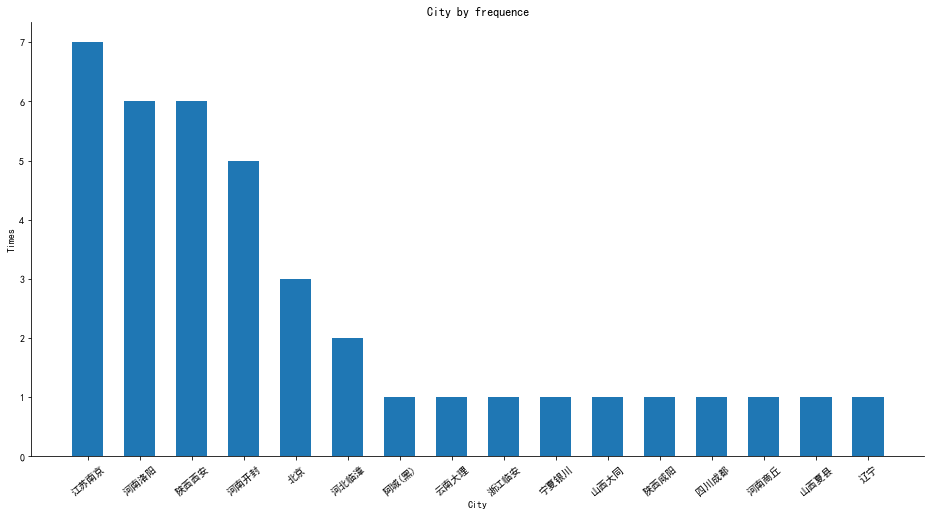

In [4]:
d=data()
path="中国朝代及都城表.html"
position, proByTime=d.getData(path)
d.plt_data(position)

In [5]:
staT = {}
staY = {}
scatx = []
scaty = []
for key in proByTime.keys():
    staT[key] = len(proByTime[key])
    scatx.append(staT[key])
    staY[key] = np.sum(proByTime[key]) / staT[key]
    scaty.append(staY[key])

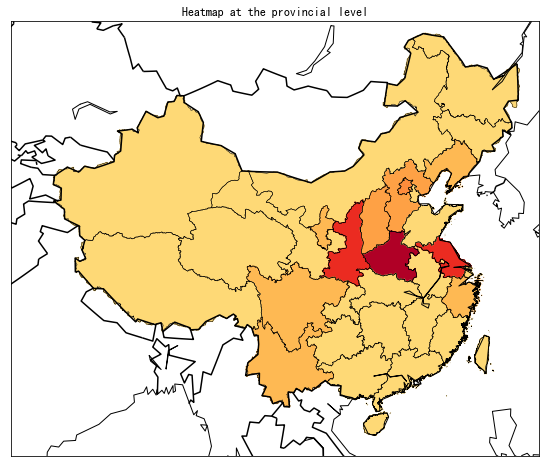

In [6]:
plt.figure(figsize=(16,8))
m = Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, projection='lcc', lat_1=33, lat_2=45, lon_0=100)
m.drawcoastlines()
m.drawcountries(linewidth=1.5)
m.readshapefile("gadm36_CHN_1",'states',drawbounds=True)
m.readshapefile("gadm36_TWN_0",'taiwan',drawbounds=True)
cmap = plt.cm.YlOrRd
plist = staT
vmax = 15
vmin = -1
#print(m.states)
statenames=[]
colors={}

for shapedict in m.states_info:
    statename = shapedict['NL_NAME_1']
    p = statename.split('|')
    if len(p) > 1:
        s = p[1]
    else:
        s = p[0]
    s = s[:2]
    if s == '黑龍':
        s = '黑龙'
    statenames.append(s)
    if s not in plist.keys():
        pop = 0
    else:
        pop = plist[s]
    colors[s] = cmap(np.sqrt((pop - vmin) / (vmax - vmin)))[:3]
    
ax = plt.gca()
ax.set_title('Heatmap at the provincial level')
for nshape, seg in enumerate(m.states):
    color = rgb2hex(colors[statenames[nshape]])
    poly = Polygon(seg, facecolor=color, edgecolor=color)
    ax.add_patch(poly)
color_taiwan = cmap(np.sqrt((0 - vmin) / (vmax - vmin)))[:3]

for nshape, seg in enumerate(m.taiwan):
    color = rgb2hex(color_taiwan)
    poly = Polygon(seg, facecolor=color, edgecolor=color)
    ax.add_patch(poly)
plt.show()

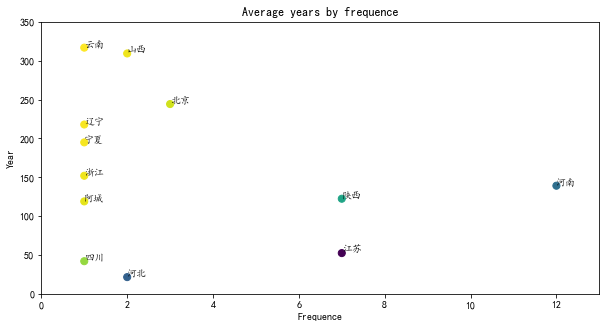

In [7]:
plt.figure(figsize=(10,5))
plt.scatter(scatx, scaty, s=50,c=np.arctan2(scaty, scatx))
for key in proByTime.keys():
    plt.annotate(key, xy=(staT[key], staY[key]),fontproperties=zhfont1)
plt.xlim([0,13])
plt.ylim([0,350])
plt.xlabel("Frequence")
plt.ylabel("Year")
plt.title('Average years by frequence')
plt.show()